#Load Data

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/pima-indians-diabetes-database")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/pima-indians-diabetes-database


#data understanding and check missing values

In [23]:
import pandas as pd

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import (
  cross_validate,
  train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier

In [3]:
df = pd.read_csv(path + "/diabetes.csv")
df.shape

(768, 9)

In [4]:
df.sample(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
760,2,88,58,26,16,28.4,0.766,22,0
387,8,105,100,36,0,43.3,0.239,45,1
238,9,164,84,21,0,30.8,0.831,32,1
513,2,91,62,0,0,27.3,0.525,22,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


#Check Duplicates

In [6]:
df.drop_duplicates().shape

(768, 9)

In [7]:
df.groupby(df.columns.tolist()).size().sort_values(ascending=False).head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  BMI   DiabetesPedigreeFunction  Age  Outcome
12           140      82             43             325      39.2  0.528                     58   1          1
             121      78             17             0        26.5  0.259                     62   0          1
             106      80             0              0        23.6  0.137                     44   0          1
             100      84             33             105      30.0  0.488                     46   0          1
             92       62             7              258      27.6  0.926                     44   1          1
dtype: int64

In [8]:
df = df.drop_duplicates()
df.shape

(768, 9)

In [9]:
df.sample(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
216,5,109,62,41,129,35.8,0.514,25,1
157,1,109,56,21,135,25.2,0.833,23,0
634,10,92,62,0,0,25.9,0.167,31,0
618,9,112,82,24,0,28.2,1.282,50,1
341,1,95,74,21,73,25.9,0.673,36,0


#Multicorr Check

<Axes: >

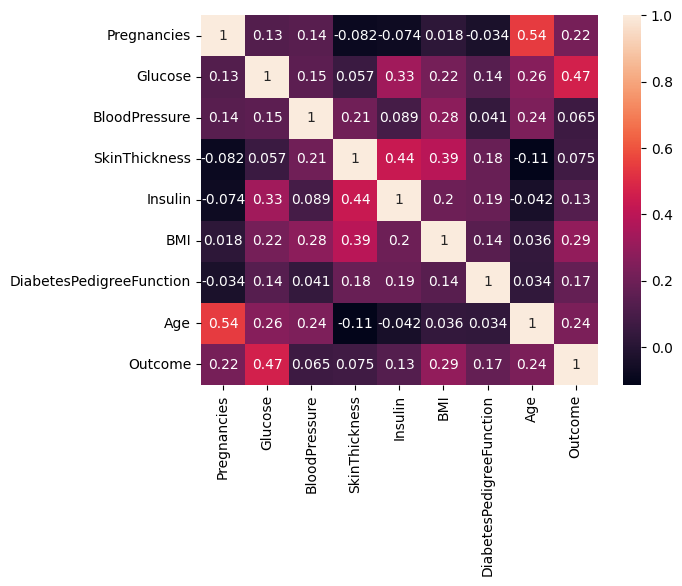

In [11]:
sns.heatmap(df.corr(), annot=True)

#Outlier Check

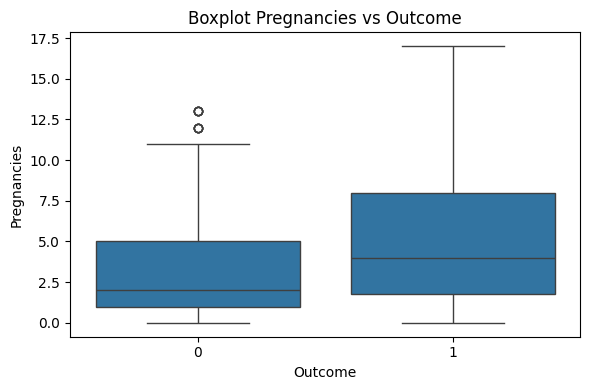

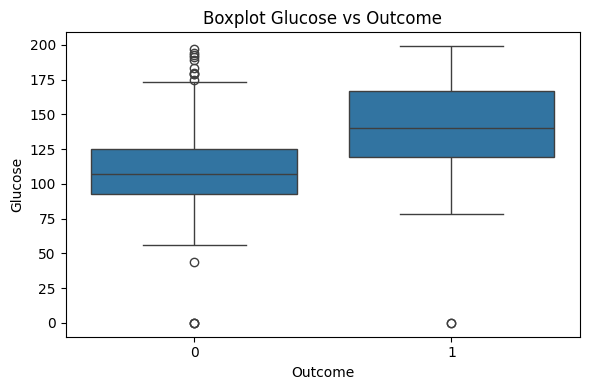

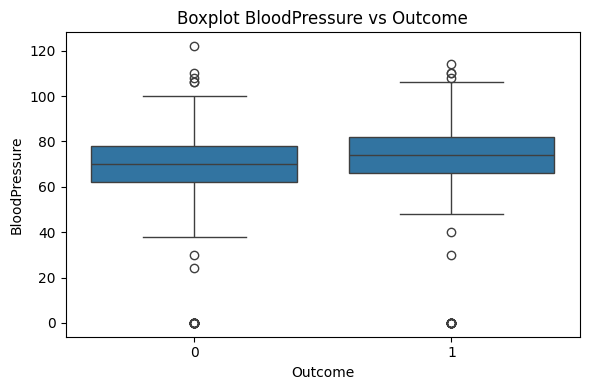

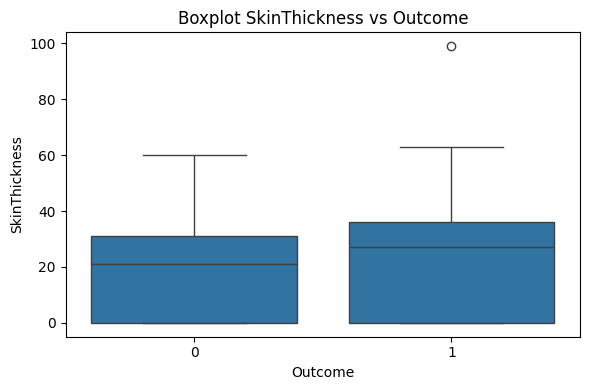

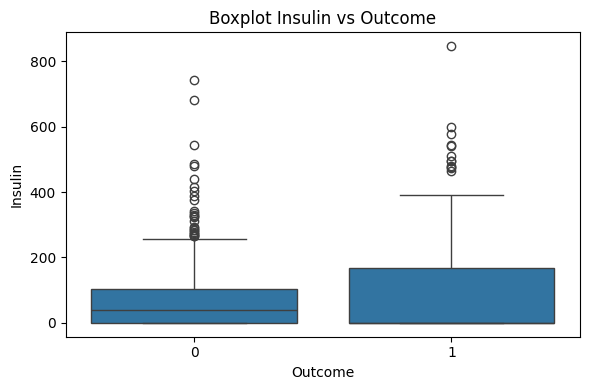

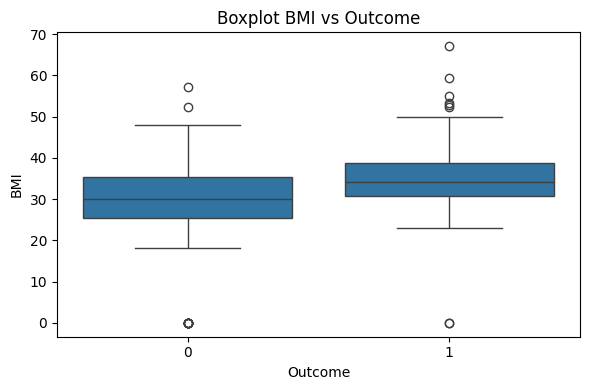

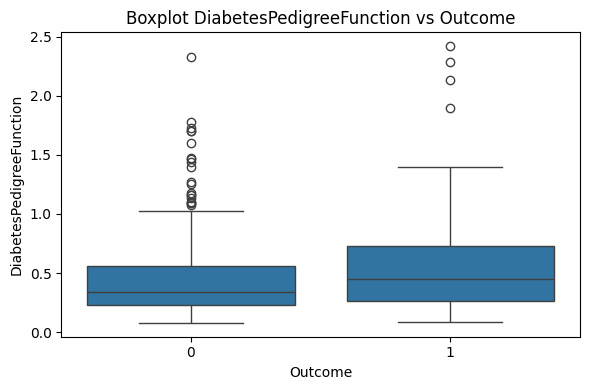

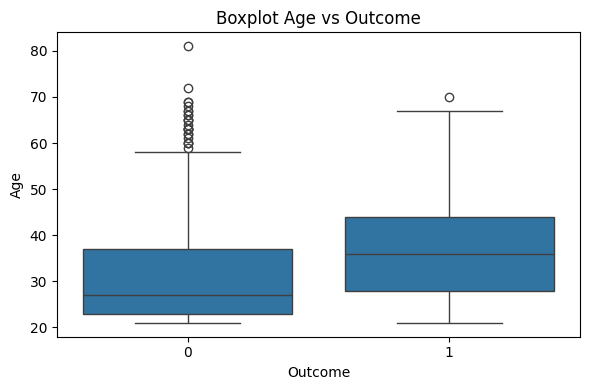

In [12]:
for col in df.select_dtypes(include='number').columns:
    if col != 'Outcome':
        plt.figure(figsize=(6, 4))
        sns.boxplot(x='Outcome', y=col, data=df)
        plt.title(f'Boxplot {col} vs Outcome')
        plt.tight_layout()
        plt.show()

#EDA

In [13]:
target_column = 'Outcome'

numeric_columns = [
  'Pregnancies',
  'Glucose',
  'BloodPressure',
  'SkinThickness',
  'Insulin',
  'BMI',
  'DiabetesPedigreeFunction',
  'Age',
]

##Target

In [14]:
df.groupby(target_column).size()

,0
Outcome,
0,500
1,268


In [15]:
268 / (500+268)

0.3489583333333333

##Biavariate analysis

###Numeric vs Numeric


In [16]:
df_corr = df[numeric_columns].corr(method='spearman')
df_corr

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.000000,0.130734,0.185127,-0.085222,-0.126723,0.000132,-0.043242,0.607216
Glucose,0.130734,1.000000,0.235191,0.060022,0.213206,0.231141,0.091293,0.285045
BloodPressure,0.185127,0.235191,1.000000,0.126486,-0.006771,0.292870,0.030046,0.350895
SkinThickness,-0.085222,0.060022,0.126486,1.000000,0.541000,0.443615,0.180390,-0.066795
Insulin,-0.126723,0.213206,-0.006771,0.541000,1.000000,0.192726,0.221150,-0.114213
BMI,0.000132,0.231141,0.292870,0.443615,0.192726,1.000000,0.141192,0.131186
DiabetesPedigreeFunction,-0.043242,0.091293,0.030046,0.180390,0.221150,0.141192,1.000000,0.042909
Age,0.607216,0.285045,0.350895,-0.066795,-0.114213,0.131186,0.042909,1.000000


<Axes: >

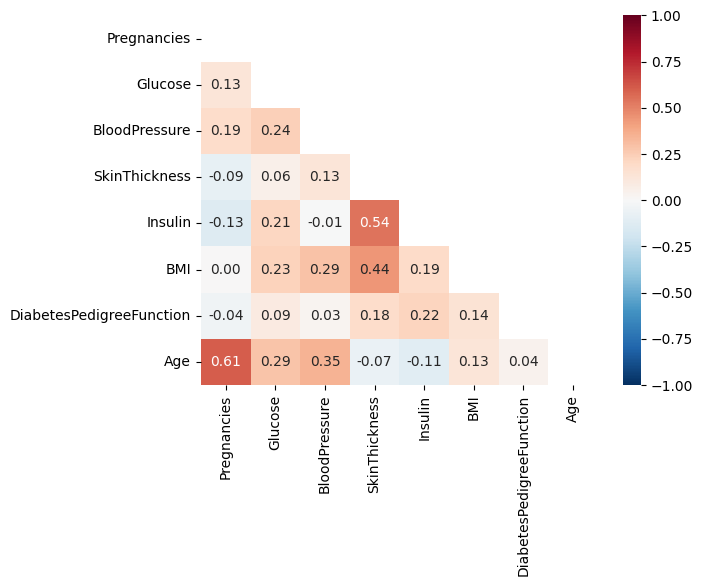

In [18]:
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(
  df_corr,
  vmin = -1,
  vmax = 1,
  annot = True,
  mask = mask,
  fmt = '.2f',
  cmap = 'RdBu_r',
)

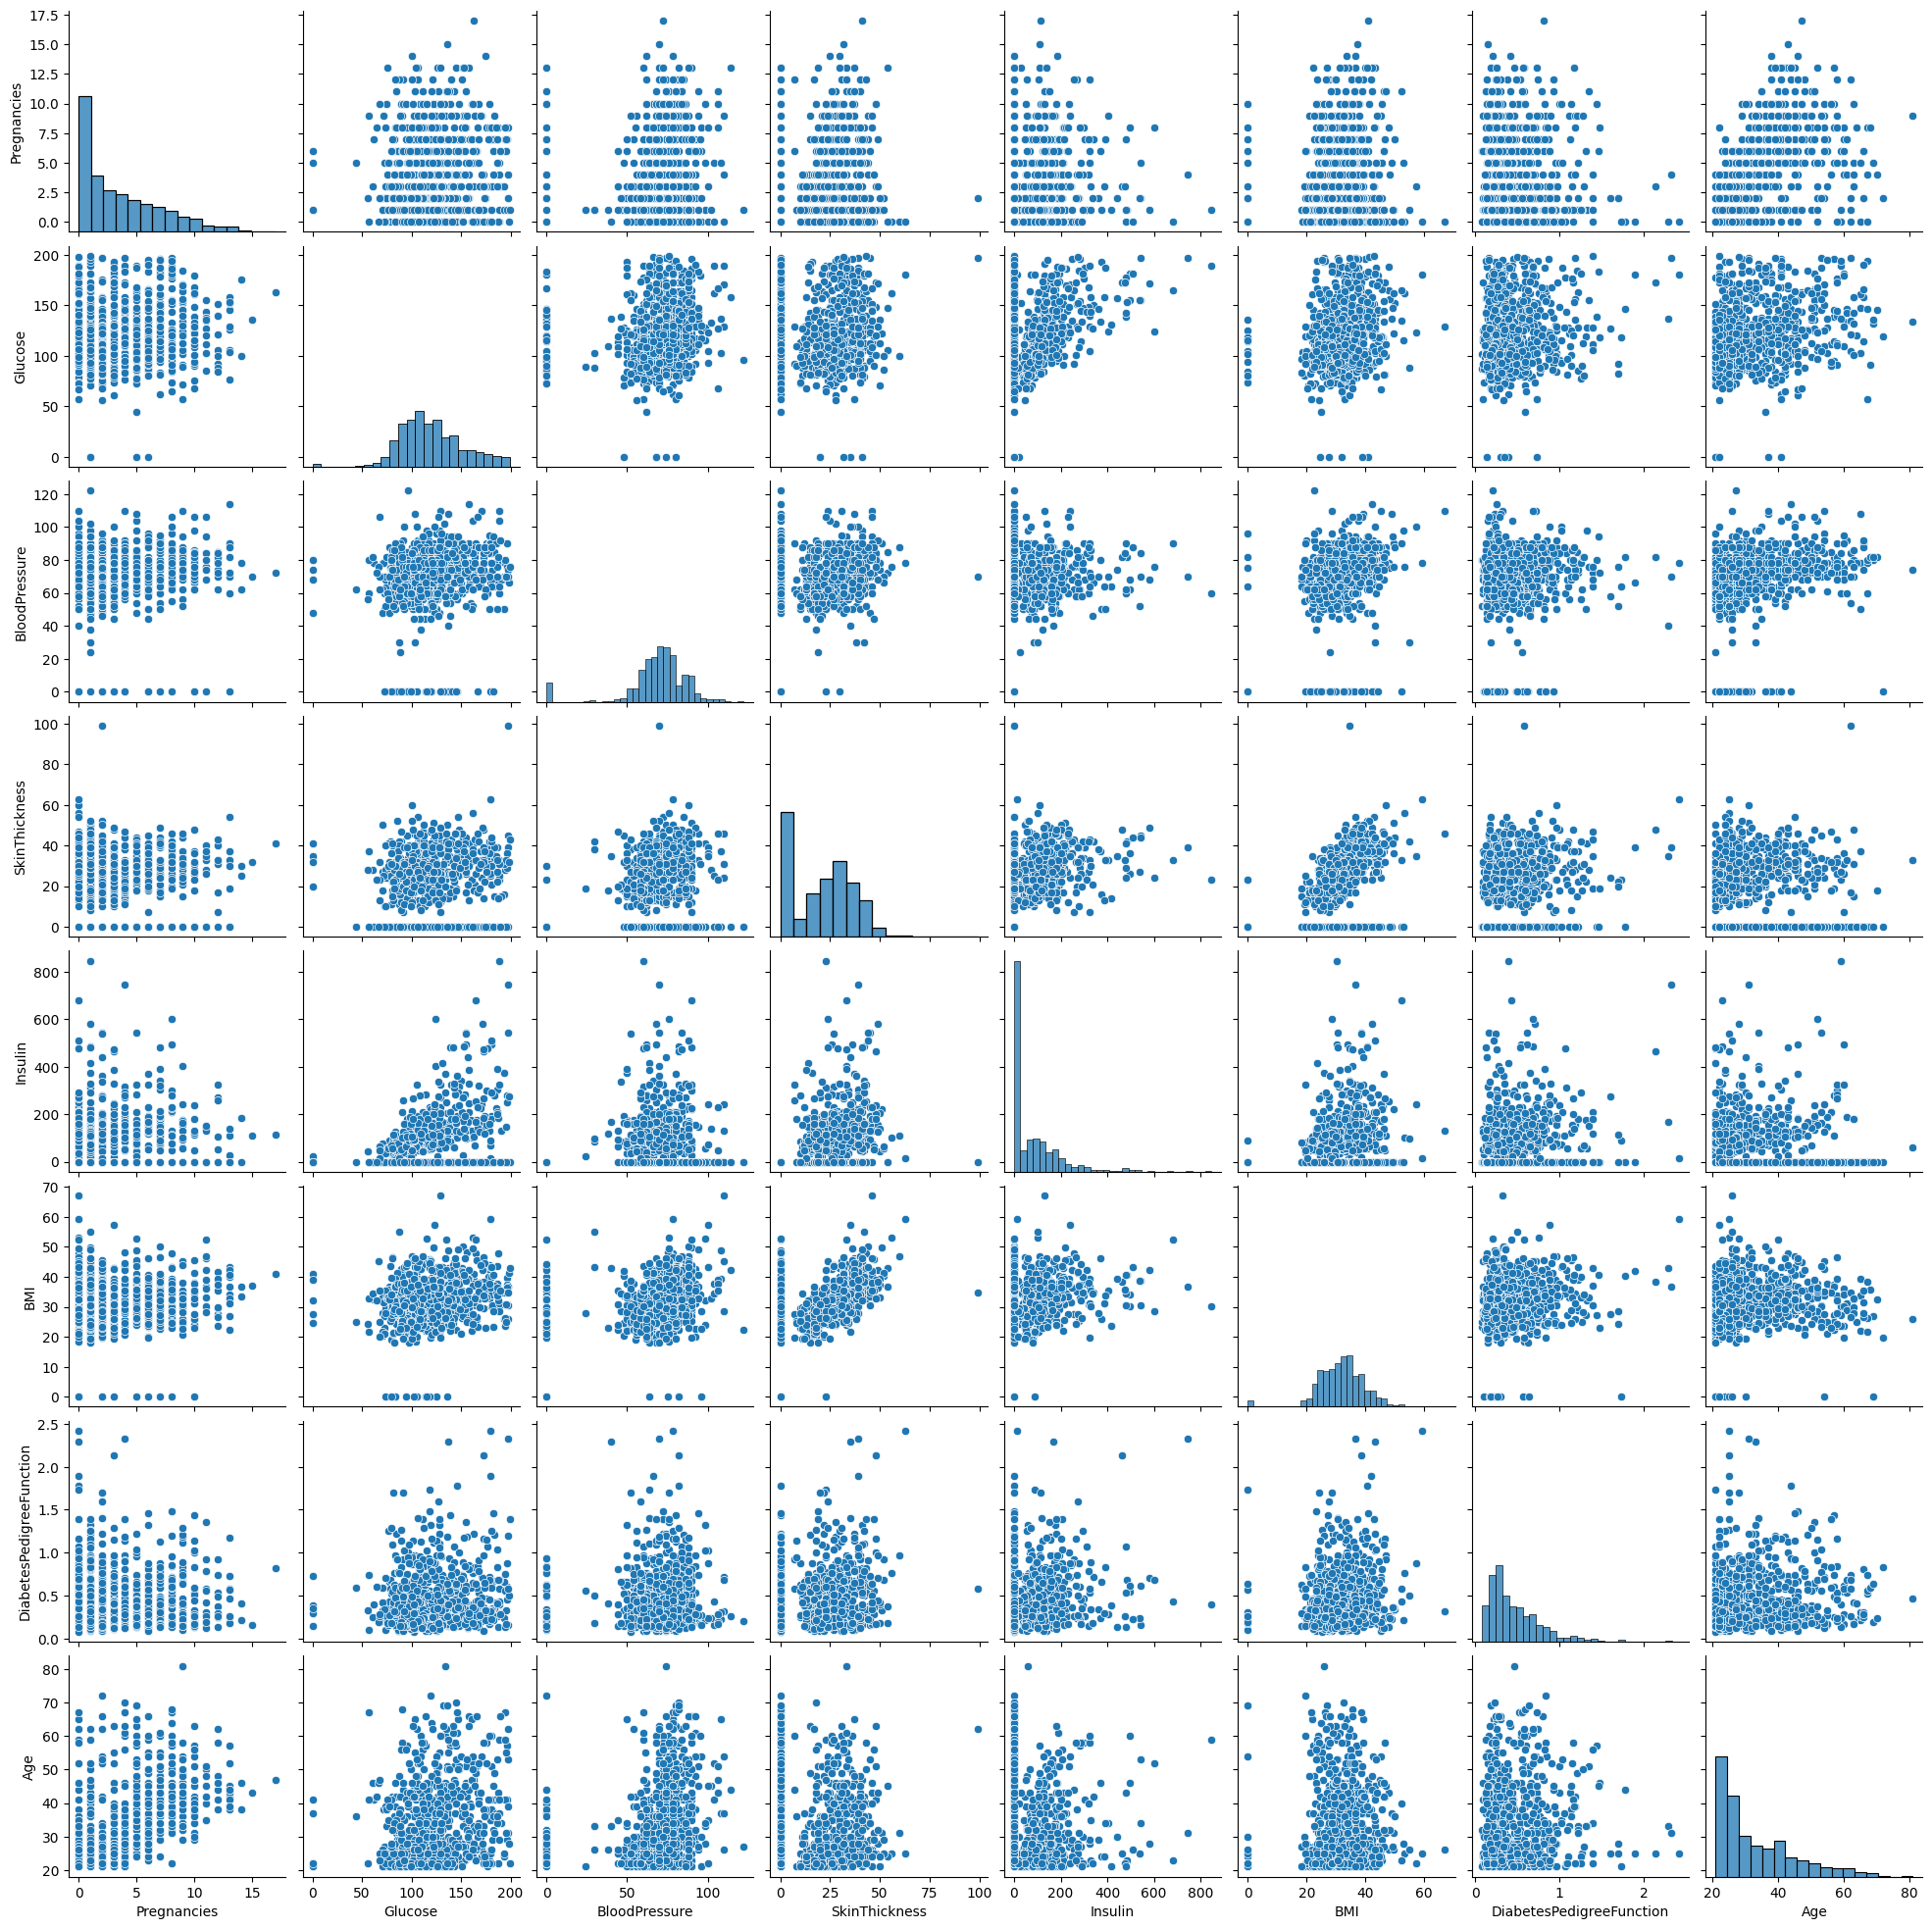

In [19]:
sns.pairplot(df[numeric_columns])

#Preprocess Data

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
  df.drop(columns=target_column),
  df[target_column],
  test_size=0.2,
  random_state=42,
  stratify=df[target_column],
)

In [27]:
X_train.shape

(614, 8)

In [28]:
X_test.shape

(154, 8)

##Tranformation Data

In [29]:
units = {
  'Pregnancies': 1,
  'Glucose': 1,
  'BloodPressure': 1,
  'SkinThickness': 1,
  'Insulin': 1,
  'BMI': 1,
  'DiabetesPedigreeFunction': 1,
  'Age': 1,
}

# Inisialisasi scaler
scaler = MinMaxScaler()

# Fit dan transform
X_train_scaled = scaler.fit_transform(X_train[numeric_columns])
X_test_scaled = scaler.transform(X_test[numeric_columns])

# Buat nama kolom baru
scaled_columns = [col + 'Scaled' for col in numeric_columns]

# Tambahkan hasil scaling ke X_train dan X_test
X_train[scaled_columns] = pd.DataFrame(X_train_scaled, columns=scaled_columns, index=X_train.index)
X_test[scaled_columns] = pd.DataFrame(X_test_scaled, columns=scaled_columns, index=X_test.index)

# Drop kolom asli
X_train = X_train.drop(columns=numeric_columns)
X_test = X_test.drop(columns=numeric_columns)

# Ambil info dari scaler
mins = scaler.data_min_
maxs = scaler.data_max_
scales = scaler.scale_
changes = [scale * units[col] for scale, col in zip(scales, numeric_columns)]

# Tampilkan DataFrame hasil analisis
pd.DataFrame({
  'column': numeric_columns,
  'unit': [units[c] for c in numeric_columns],
  'min': mins,
  'max': maxs,
  'change': changes,
})

,column,unit,min,max,change
0,Pregnancies,1,0.000,17.000,0.058824
1,Glucose,1,0.000,199.000,0.005025
2,BloodPressure,1,0.000,122.000,0.008197
3,SkinThickness,1,0.000,99.000,0.010101
4,Insulin,1,0.000,744.000,0.001344
5,BMI,1,0.000,67.100,0.014903
6,DiabetesPedigreeFunction,1,0.084,2.329,0.445434
7,Age,1,21.000,81.000,0.016667


In [30]:
X_train.sample(5)

,PregnanciesScaled,GlucoseScaled,BloodPressureScaled,SkinThicknessScaled,InsulinScaled,BMIScaled,DiabetesPedigreeFunctionScaled,AgeScaled
761,0.529412,0.854271,0.606557,0.313131,0.000000,0.655738,0.142094,0.366667
611,0.176471,0.874372,0.475410,0.222222,0.260753,0.490313,0.226726,0.250000
228,0.235294,0.989950,0.573770,0.393939,1.000000,0.546945,1.000000,0.166667
71,0.294118,0.698492,0.524590,0.353535,0.188172,0.426230,0.145657,0.083333
398,0.176471,0.412060,0.573770,0.000000,0.000000,0.314456,0.135857,0.066667


In [31]:
X_test.sample(5)

,PregnanciesScaled,GlucoseScaled,BloodPressureScaled,SkinThicknessScaled,InsulinScaled,BMIScaled,DiabetesPedigreeFunctionScaled,AgeScaled
3,0.058824,0.447236,0.540984,0.232323,0.126344,0.418778,0.036971,0.000000
238,0.529412,0.824121,0.688525,0.212121,0.000000,0.459016,0.332739,0.183333
436,0.705882,0.703518,0.696721,0.333333,0.000000,0.557377,0.071269,0.333333
235,0.235294,0.859296,0.590164,0.000000,0.000000,0.649776,0.175947,0.083333
366,0.352941,0.623116,0.590164,0.000000,0.000000,0.411326,0.126503,0.133333


#Select Model (Basic)

##kNN

###Train

In [32]:
model = KNeighborsClassifier(n_neighbors = 5)
model.fit(X_train, y_train)

KNeighborsClassifier()

###Evaluate

In [33]:
y_train_pred = model.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87       400
           1       0.79      0.67      0.73       214

    accuracy                           0.82       614
   macro avg       0.82      0.79      0.80       614
weighted avg       0.82      0.82      0.82       614



In [34]:
y_test_pred = model.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       100
           1       0.59      0.59      0.59        54

    accuracy                           0.71       154
   macro avg       0.69      0.69      0.69       154
weighted avg       0.71      0.71      0.71       154



###Interpret

<Axes: xlabel='GlucoseScaled', ylabel='BMIScaled'>

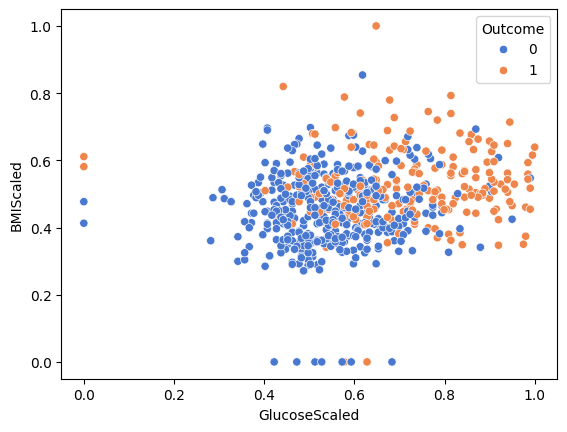

In [35]:
sns.scatterplot(
  X_train,
  x='GlucoseScaled',
  y='BMIScaled',
  hue=y_train,
  palette='muted',
)

##Logistic Regression

###Train

In [36]:
model = LogisticRegression(
  penalty = 'l2',
  C = 1.0,
  solver = 'lbfgs',
  random_state = 11,
)

model.fit(X_train, y_train)

LogisticRegression(random_state=11)

###Evaluate

In [37]:
y_train_pred = model.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85       400
           1       0.78      0.53      0.63       214

    accuracy                           0.79       614
   macro avg       0.78      0.73      0.74       614
weighted avg       0.78      0.79      0.77       614



In [38]:
y_test_pred = model.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       100
           1       0.67      0.48      0.56        54

    accuracy                           0.73       154
   macro avg       0.71      0.68      0.68       154
weighted avg       0.73      0.73      0.72       154



###Interpret

In [39]:
df_feature = pd.DataFrame({
  'feature': X_train.columns,
  'coef': model.coef_[0],
  'coef_abs': abs(model.coef_[0]),
})
df_feature['polar'] = np.where(
  df_feature['coef'] < 0,
  'negative',
  'positive'
)

df_feature = df_feature.sort_values('coef_abs', ascending=False)
df_feature

,feature,coef,coef_abs,polar
1,GlucoseScaled,4.692366,4.692366,positive
5,BMIScaled,3.067982,3.067982,positive
0,PregnanciesScaled,1.360415,1.360415,positive
6,DiabetesPedigreeFunctionScaled,1.220758,1.220758,positive
7,AgeScaled,1.016321,1.016321,positive
2,BloodPressureScaled,-0.418451,0.418451,negative
3,SkinThicknessScaled,0.385592,0.385592,positive
4,InsulinScaled,0.105690,0.105690,positive


(-3.0, 2.0)

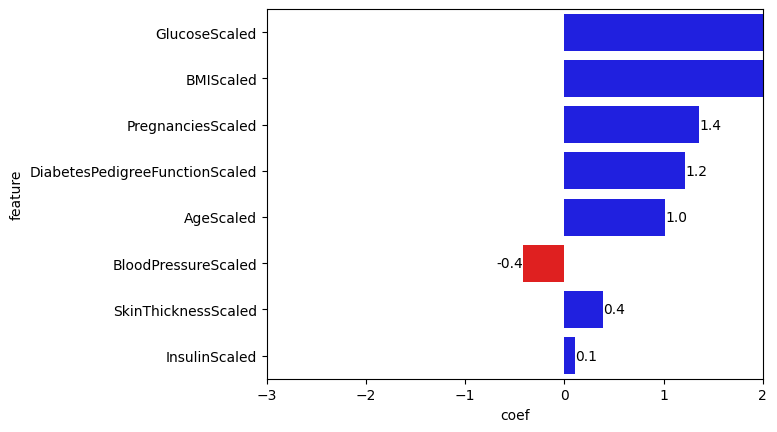

In [40]:
ax = sns.barplot(
  df_feature,
  x='coef',
  y='feature',
  hue='polar',
  palette={'positive': 'blue', 'negative': 'red'},
  legend=False,
)
ax.bar_label(ax.containers[0], fmt='%.1f')
ax.bar_label(ax.containers[1], fmt='%.1f')
ax.set_xlim(-3, 2)

##Random Forest

###Train

In [41]:
model = RandomForestClassifier(
  n_estimators = 100,
  criterion = 'gini',
  max_depth = 5,
  ccp_alpha = 0.0,
  random_state = 11,
)

model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=11)

###Evaluate

In [42]:
y_train_pred = model.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89       400
           1       0.89      0.65      0.75       214

    accuracy                           0.85       614
   macro avg       0.86      0.80      0.82       614
weighted avg       0.85      0.85      0.84       614



In [43]:
y_test_pred = model.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.77      0.86      0.82       100
           1       0.67      0.54      0.60        54

    accuracy                           0.75       154
   macro avg       0.72      0.70      0.71       154
weighted avg       0.74      0.75      0.74       154



###Interpret

<Axes: xlabel='feature_importance', ylabel='feature'>

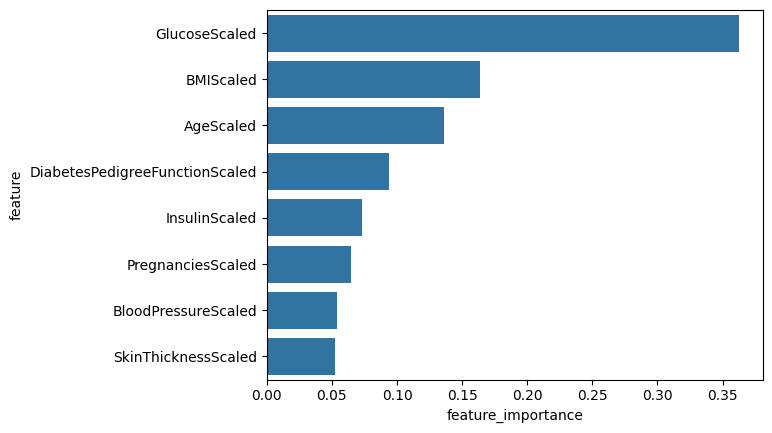

In [44]:
df_feature_importance = pd.DataFrame({
  'feature': model.feature_names_in_,
  'feature_importance': model.feature_importances_,
}).sort_values('feature_importance', ascending=False)

sns.barplot(
  df_feature_importance,
  x = 'feature_importance',
  y = 'feature',
)

##Smote

###SMOTE to Train Data

In [45]:
from imblearn.over_sampling import SMOTE

# Terapkan SMOTE ke data train
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Sebelum SMOTE:", y_train.value_counts())
print("Setelah SMOTE:", pd.Series(y_train_resampled).value_counts())

Sebelum SMOTE: Outcome
0    400
1    214
Name: count, dtype: int64
Setelah SMOTE: Outcome
0    400
1    400
Name: count, dtype: int64


##XGBoost

###Train and Evaluate

=== Classification Report (XGBoost) ===
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       100
           1       0.60      0.63      0.61        54

    accuracy                           0.72       154
   macro avg       0.70      0.70      0.70       154
weighted avg       0.72      0.72      0.72       154

=== Confusion Matrix ===
[[77 23]
 [20 34]]
ROC AUC Score: 0.803


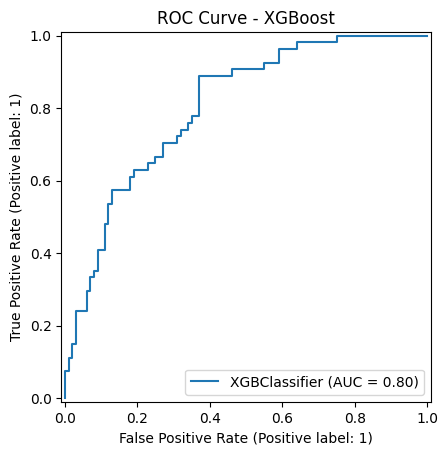

In [46]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# Inisialisasi model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Latih model
xgb.fit(X_train_resampled, y_train_resampled)

# Prediksi
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]  # Probabilitas untuk ROC

# Evaluasi
print("=== Classification Report (XGBoost) ===")
print(classification_report(y_test, y_pred_xgb))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred_xgb))

# ROC AUC Score
auc = roc_auc_score(y_test, y_proba_xgb)
print(f"ROC AUC Score: {auc:.3f}")

# ROC Curve
RocCurveDisplay.from_estimator(xgb, X_test, y_test)
plt.title("ROC Curve - XGBoost")
plt.show()

###Interpret

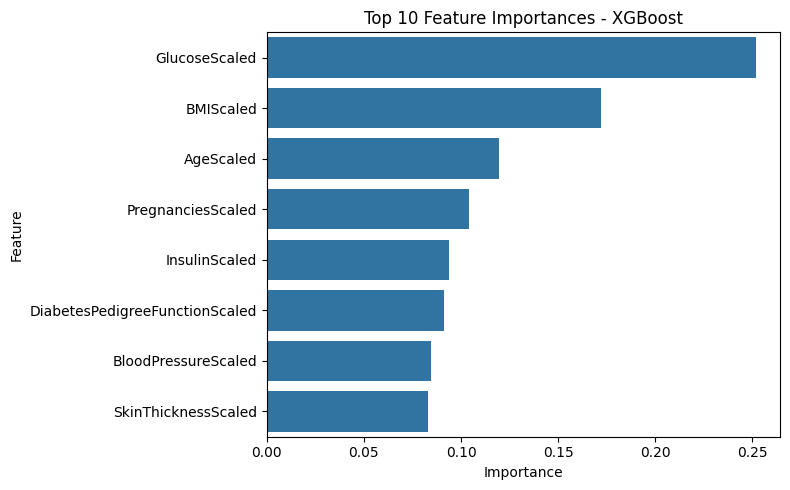

In [47]:
# Ambil fitur dan importance dari model
feature_importance = xgb.feature_importances_
features = X_train_resampled.columns

# Dataframe importance
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Visualisasi
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title("Top 10 Feature Importances - XGBoost")
plt.tight_layout()
plt.show()

#Import Model

In [54]:
import joblib
joblib.dump(xgb, "xgb_diabetes_model.pkl")

['xgb_diabetes_model.pkl']

#Save Scaler

In [51]:
import joblib
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

#Testing input new data (Testing Model)

In [56]:
# Load model dan scaler
model = joblib.load("xgb_diabetes_model.pkl")
scaler = joblib.load("scaler.pkl")

# Data baru (misalnya dari user)
input_data = pd.DataFrame([{
    'Pregnancies': 2,
    'Glucose': 140,
    'BloodPressure': 80,
    'SkinThickness': 32,
    'Insulin': 94,
    'BMI': 35.0,
    'DiabetesPedigreeFunction': 0.5,
    'Age': 45
}])

# Scaling + Prediksi
input_scaled = scaler.transform(input_data)
pred = model.predict(input_scaled)
proba = model.predict_proba(input_scaled)[0][1]

# Hasil
print("Prediksi:", "Diabetes" if pred[0] == 1 else "Tidak Diabetes")
print(f"Probabilitas Diabetes: {proba*100:.1f}%")

Prediksi: Diabetes
Probabilitas Diabetes: 99.3%


In [57]:
from google.colab import files

# Download model dan scaler
files.download('xgb_diabetes_model.pkl')
files.download('scaler.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>